In [12]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
from tqdm import tqdm

from lisatools.utils.constants import *
from bbhx.waveformbuild import BBHWaveformFD
import noise_generation as noise_generation
from tools.LISASimulator import LISASimulator
from tools.time_freq_likelihood import TimeFreqLikelihood

In [13]:
Tobs = YRSID_SI/12
dt = 5.
include_T_channel = False # Set to True if you want to include the T channel in the simulation, otherwise only A and E channels will be included.

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

m1 = 3e5
m2 = 1.5e5
a1 = 0.2
a2 = 0.4
dist = 8e3 * PC_SI * 1e6 
phi_ref = np.pi/2
f_ref = 0.0
inc = np.pi/3
lam = np.pi/1.
beta = np.pi/4.
psi = np.pi/4.
t_ref = 0.95 * Tobs
#t_ref = round(0.9 * Tobs / dt) * dt  # round to the nearest multiple of dt, to force t_ref to be a part of t_array

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(direct=False, fill=True, squeeze=False, length=1024)

data_t, data_f, f_array, t_array, sens_mat = sim(seed = 42, parameters=parameters, modes=modes, waveform_kwargs=waveform_kwargs)

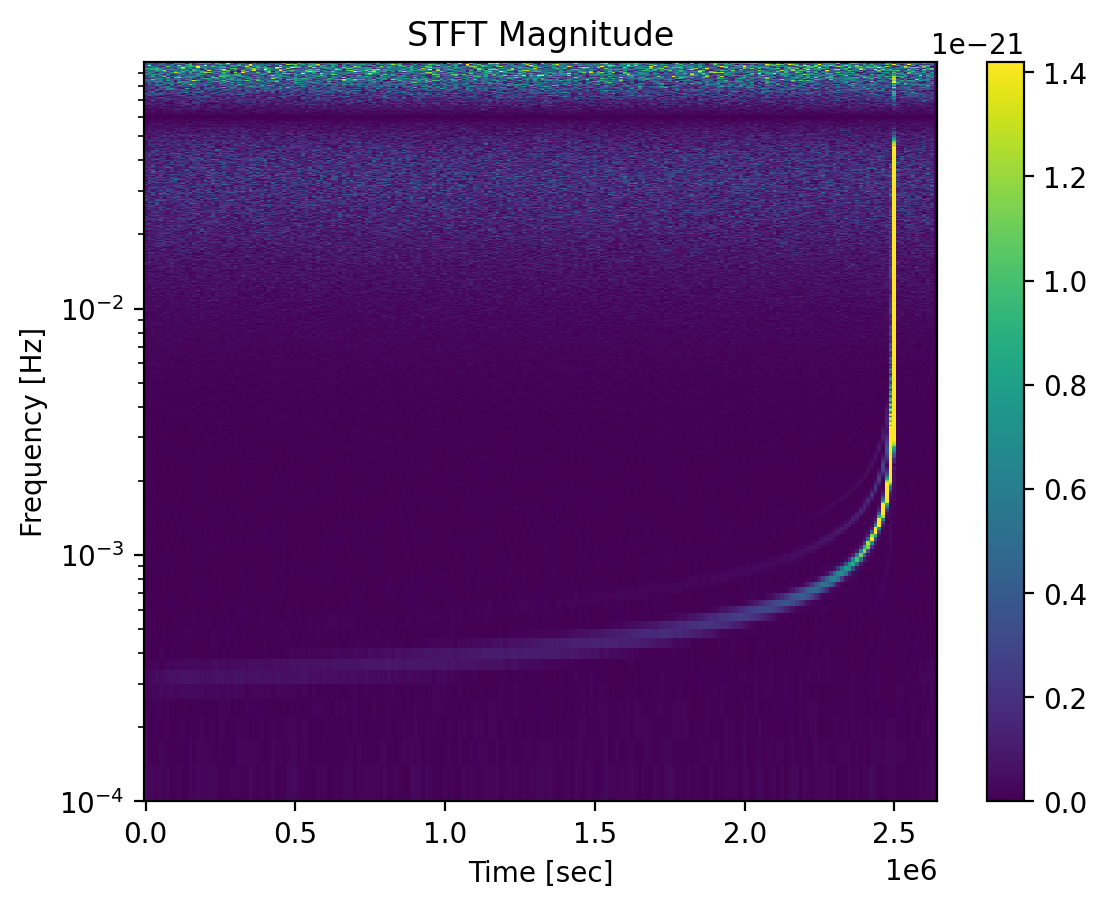

In [15]:
sim.plot_time_frequency(nperseg=5000)

In [4]:
# Check is the likelihood is zero by computing the likelihood of a template with the true parameters with the noise-free signal.
analysis_no_noise = TimeFreqLikelihood(data_t=sim.signal_t[0], wave_gen=wave_gen)
analysis_no_noise.get_stft_of_data()
analysis_no_noise.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        direct=False,
        fill=True,
        squeeze=False,
        freqs=f_array,
        modes=modes
    )
)

np.float64(0.0)

In [ ]:
nperseg_list = np.arange(4000, 6000, 200)
lam_list = np.arange(lam-np.pi/8, lam+np.pi/8, np.pi/64)
beta_list = np.arange(beta-np.pi/8, beta+np.pi/8, np.pi/64)
lam_grid, beta_grid = np.meshgrid(lam_list, beta_list)

In [ ]:
time_freq_likelihoods = []
for nperseg in tqdm(nperseg_list):
    analysis = TimeFreqLikelihood(data_t=data_t, wave_gen=wave_gen, nperseg=nperseg)
    analysis.get_stft_of_data()
    temp1 =[]
    for lam_temp in tqdm(lam_list):
        temp2 = []
        for beta_temp in beta_list:
            likelihood_value = analysis.calculate_time_frequency_likelihood(
                m1,
                m2, 
                a1,
                a2,
                dist, 
                phi_ref,
                f_ref, 
                inc,
                lam_temp,
                beta_temp,
                psi,
                t_ref,
                waveform_kwargs=dict(
                    length=1024, 
                    direct=False,
                    fill=True,
                    squeeze=False,
                    freqs=f_array,
                    modes=modes
                )
            )
            temp2.append(likelihood_value)
        temp1.append(temp2)
    time_freq_likelihoods.append(temp1)

time_freq_likelihoods = np.array(time_freq_likelihoods)

100%|██████████| 10/10 [11:33<00:00, 69.39s/it]


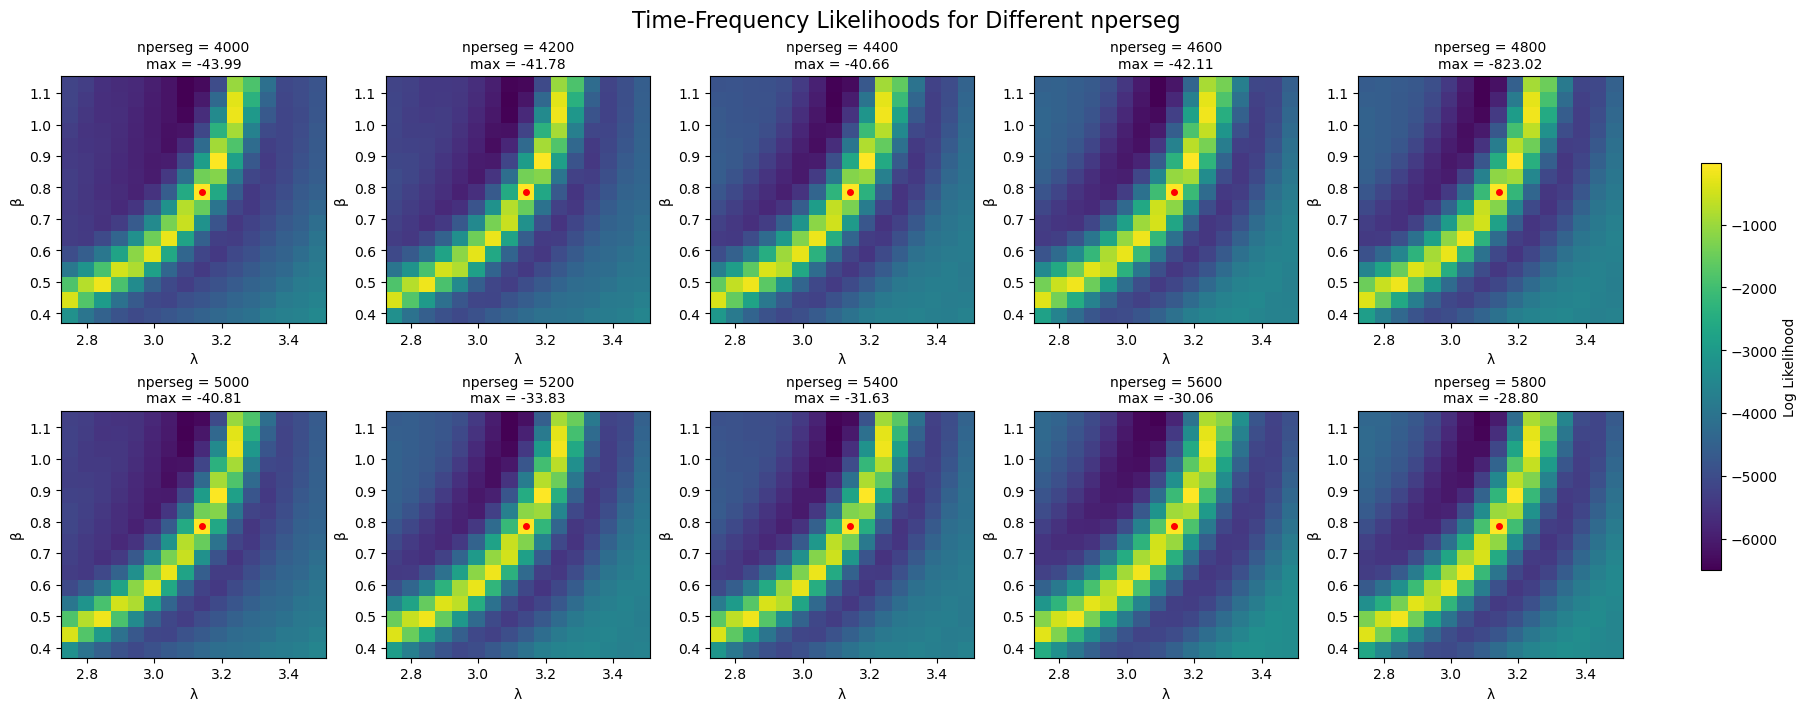

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the meshgrid if not already done
lam_grid, beta_grid = np.meshgrid(lam_list, beta_list)

fig, axes = plt.subplots(2, 5, figsize=(18, 7), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    likelihood = time_freq_likelihoods[i]

    # Plot the likelihood heatmap
    pcm = ax.pcolormesh(lam_grid, beta_grid, likelihood, shading='auto', cmap='viridis')

    # Find the index of the max value
    max_idx = np.unravel_index(np.argmax(likelihood), likelihood.shape)
    max_beta = beta_list[max_idx[0]]
    max_lam = lam_list[max_idx[1]]
    max_val = likelihood[max_idx]

    # Add a red dot at the max location
    ax.plot(max_lam, max_beta, 'ro', markersize=4)

    # Title with nperseg and max value
    ax.set_title(f'nperseg = {nperseg_list[i]}\nmax = {max_val:.2f}', fontsize=10)

    ax.set_xlabel('λ')
    ax.set_ylabel('β')

# Add a single shared colorbar
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.7)
cbar.set_label('Log Likelihood')

plt.suptitle("Time-Frequency Likelihoods for Different nperseg", fontsize=16)
plt.show()


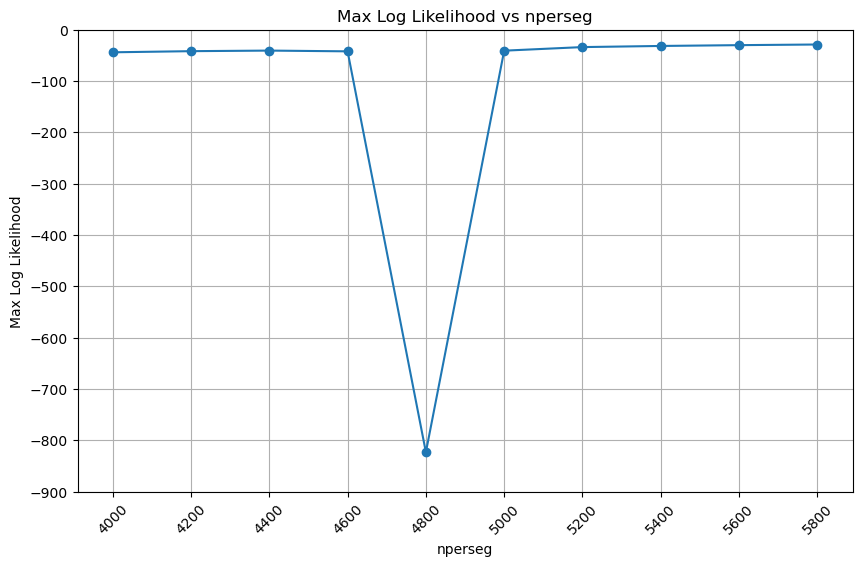

In [30]:
max_values = []
for i in range(len(nperseg_list)):
    likelihood = time_freq_likelihoods[i]
    temp = np.max(likelihood)
    max_values.append(temp)

max_values = np.array(max_values)
plt.figure(figsize=(10, 6))
plt.plot(nperseg_list, max_values, marker='o')
plt.xlabel('nperseg')
plt.ylabel('Max Log Likelihood')
plt.title('Max Log Likelihood vs nperseg')
plt.grid()
plt.xticks(nperseg_list, rotation=45)
plt.ylim(-900, 0)
plt.show()

In [45]:
lam = np.pi/1.
beta = np.pi/4.
analysis = TimeFreqLikelihood(data_t=data_t, wave_gen=wave_gen, nperseg=nperseg_list[4])
analysis.get_stft_of_data()
print(analysis.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        direct=False,
        fill=True,
        squeeze=False,
        freqs=f_array,
        modes=modes
    )
))
print(np.max(time_freq_likelihoods[4]))

-823.0234172624971
-823.0234172624807


In [49]:
nperseg_list_4800 = np.arange(4600, 5000, 40)
time_freq_likelihoods_4800 = []

for nperseg in tqdm(nperseg_list_4800):
    analysis = TimeFreqLikelihood(data_t=data_t, wave_gen=wave_gen, nperseg=nperseg)
    analysis.get_stft_of_data()
    temp1 =[]
    for lam_temp in tqdm(lam_list):
        temp2 = []
        for beta_temp in beta_list:
            likelihood_value = analysis.calculate_time_frequency_likelihood(
                m1,
                m2, 
                a1,
                a2,
                dist, 
                phi_ref,
                f_ref, 
                inc,
                lam_temp,
                beta_temp,
                psi,
                t_ref,
                waveform_kwargs=dict(
                    length=1024, 
                    direct=False,
                    fill=True,
                    squeeze=False,
                    freqs=f_array,
                    modes=modes
                )
            )
            temp2.append(likelihood_value)
        temp1.append(temp2)
    time_freq_likelihoods_4800.append(temp1)

time_freq_likelihoods_4800 = np.array(time_freq_likelihoods_4800)

100%|██████████| 10/10 [11:43<00:00, 70.35s/it]


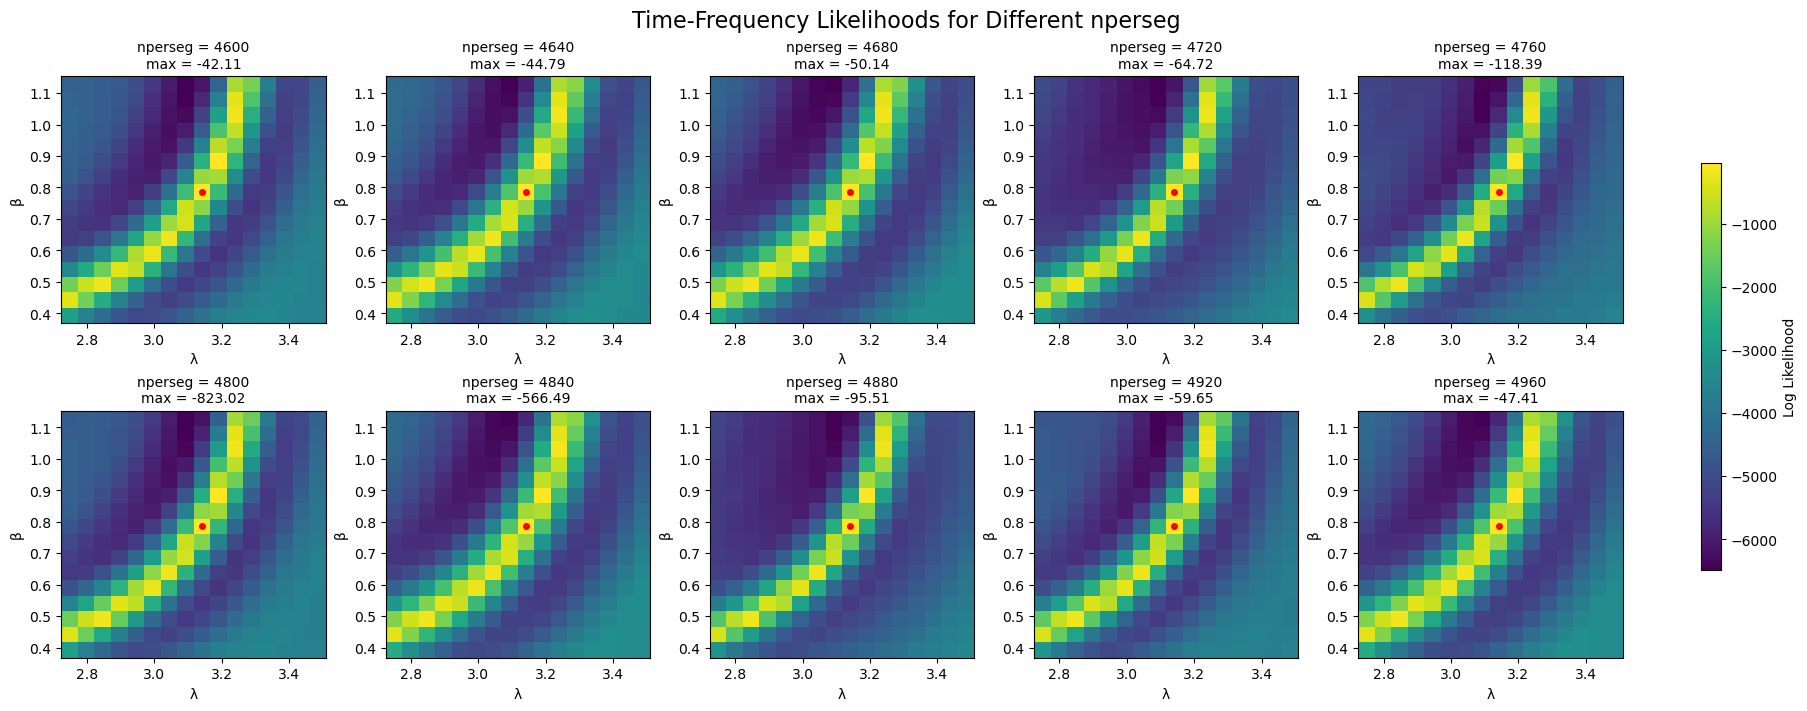

In [53]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    likelihood = time_freq_likelihoods_4800[i]

    # Plot the likelihood heatmap
    pcm = ax.pcolormesh(lam_grid, beta_grid, likelihood, shading='auto', cmap='viridis')

    # Find the index of the max value
    max_idx = np.unravel_index(np.argmax(likelihood), likelihood.shape)
    max_beta = beta_list[max_idx[0]]
    max_lam = lam_list[max_idx[1]]
    max_val = likelihood[max_idx]

    # Add a red dot at the max location
    ax.plot(max_lam, max_beta, 'ro', markersize=4)

    # Title with nperseg and max value
    ax.set_title(f'nperseg = {nperseg_list_4800[i]}\nmax = {max_val:.2f}', fontsize=10)

    ax.set_xlabel('λ')
    ax.set_ylabel('β')

# Add a single shared colorbar
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.7)
cbar.set_label('Log Likelihood')

plt.suptitle("Time-Frequency Likelihoods for Different nperseg", fontsize=16)
plt.show()


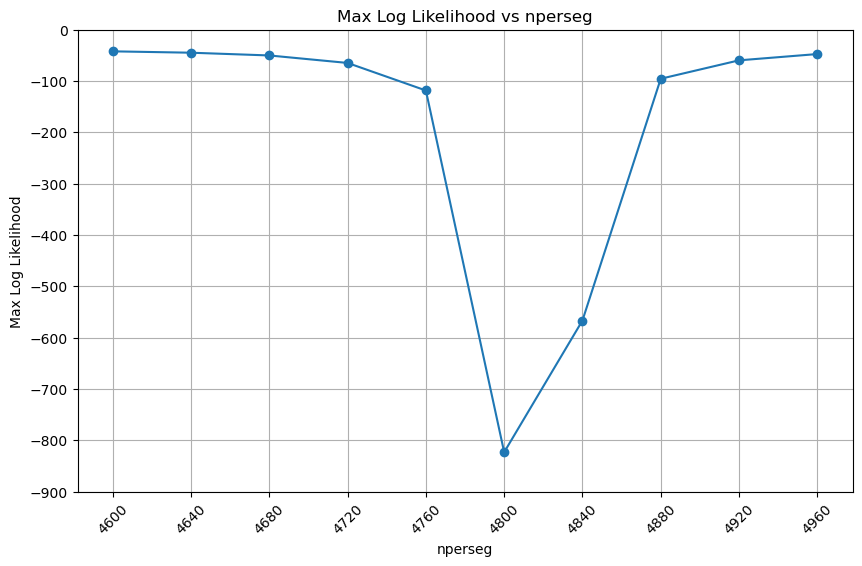

In [51]:
max_values_4800 = []
for i in range(len(nperseg_list_4800)):
    likelihood = time_freq_likelihoods_4800[i]
    temp = np.max(likelihood)
    max_values_4800.append(temp)

max_values_4800 = np.array(max_values_4800)
plt.figure(figsize=(10, 6))
plt.plot(nperseg_list_4800, max_values_4800, marker='o')
plt.xlabel('nperseg')
plt.ylabel('Max Log Likelihood')
plt.title('Max Log Likelihood vs nperseg')
plt.grid()
plt.xticks(nperseg_list_4800, rotation=45)
plt.ylim(-900, 0)
plt.show()

In [52]:
import os
os.system("say 'Computation is done!'")  # macOS only

0